# Earthquake Zone Anomaly Detection

In [1]:
import pandas as pd

df = pd.read_csv("data/earthquake_data_20251005_231758.csv")

df.head()

,datetime,latitude,longitude,depth,magnitude,location
0,2025-10-05 22:59:00,9.41,126.33,17,1.8,021 km N 44Â° E of Cortes (Surigao Del Sur)
1,2025-10-05 22:57:00,11.15,123.93,8,2.0,012 km N 27Â° W of City Of Bogo (Cebu)
2,2025-10-05 22:55:00,7.52,126.87,25,2.4,034 km S 80Â° E of Baganga (Davao Oriental)
3,2025-10-05 22:36:00,9.27,126.55,10,3.9,039 km S 89Â° E of Cortes (Surigao Del Sur)
4,2025-10-05 22:28:00,11.16,123.95,5,2.4,012 km N 15Â° W of City Of Bogo (Cebu)


In [2]:
data = df[["latitude", "longitude", "depth", "magnitude"]]

In [8]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

iso = IsolationForest(contamination=0.05, random_state=42)
df["anomaly_iforest"] = iso.fit_predict(data)

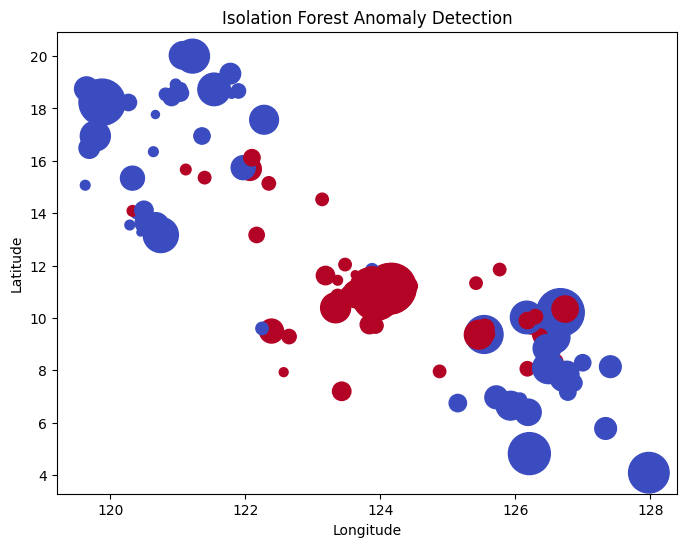

In [9]:
# -1 = anomaly, 1 = normal
plt.figure(figsize=(8,6))
plt.scatter(df["longitude"], df["latitude"],
            c=df["anomaly_iforest"], cmap="coolwarm", s=df["magnitude"]**3 * 10)
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [5]:
df[df["anomaly"] == -1].sort_values("magnitude", ascending=False).head(10)

,datetime,latitude,longitude,depth,magnitude,location,anomaly
384,2025-10-04 07:42:00,10.21,126.67,21,4.9,069 km N 72Â° E of Burgos (Surigao Del Norte),-1
120,2025-10-05 09:45:00,18.24,119.88,17,4.8,069 km N 70Â° W of Currimao (Ilocos Norte),-1
11,2025-10-05 21:16:00,4.82,126.21,10,4.5,109 km S 53Â° E of Sarangani (Davao Occidental),-1
36,2025-10-05 18:30:00,4.09,127.98,37,4.4,318 km S 61Â° E of Sarangani Island (Municipal...,-1
197,2025-10-05 02:01:00,9.37,125.54,4,4.2,004 km N 38Â° E of Jabonga (Agusan Del Norte),-1
17,2025-10-05 20:54:00,13.17,120.75,9,4.0,003 km S 86Â° W of Santa Cruz (Occidental Mind...,-1
820,2025-10-02 16:06:00,20.00,121.22,14,3.9,077 km S 62Â° W of Sabtang (Batanes),-1
3,2025-10-05 22:36:00,9.27,126.55,10,3.9,039 km S 89Â° E of Cortes (Surigao Del Sur),-1
337,2025-10-04 14:25:00,18.73,121.54,90,3.8,023 km S 55Â° E of Fuga Island (Aparri) (Cagayan),-1
388,2025-10-04 07:02:00,9.27,126.57,22,3.8,041 km S 89Â° E of Cortes (Surigao Del Sur),-1


In [10]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df["anomaly_lof"] = lof.fit_predict(data)

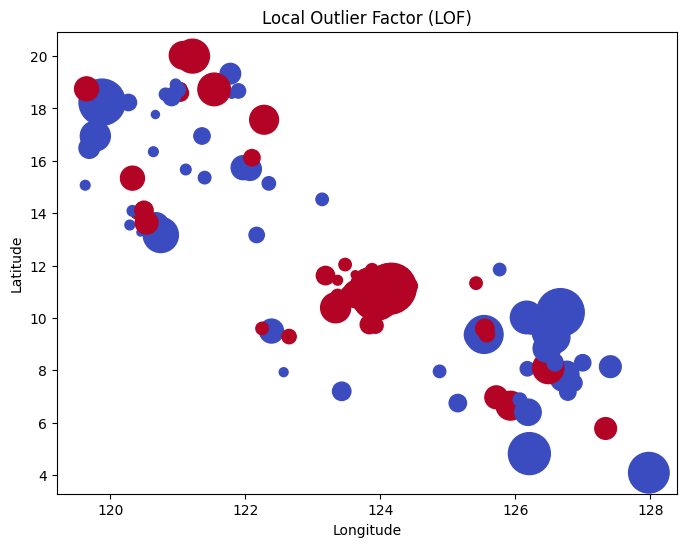

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(df["longitude"], df["latitude"],
            c=df["anomaly_lof"], cmap="coolwarm", s=df["magnitude"]**3 * 10)
plt.title("Local Outlier Factor (LOF)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [13]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)
df["anomaly_svm"] = svm.fit_predict(X_scaled)

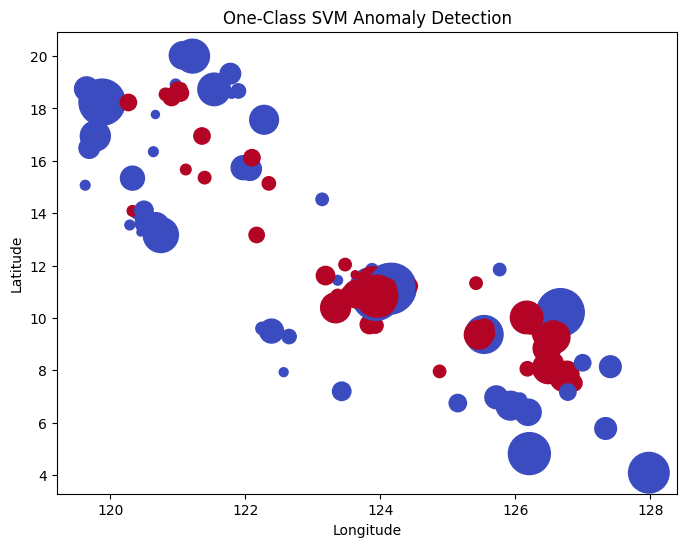

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(df["longitude"], df["latitude"],
            c=df["anomaly_svm"], cmap="coolwarm", s=df["magnitude"]**3 * 10)
plt.title("One-Class SVM Anomaly Detection")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [16]:
from sklearn.covariance import EllipticEnvelope

elliptic = EllipticEnvelope(contamination=0.05)
df["anomaly_elliptic"] = elliptic.fit_predict(data)

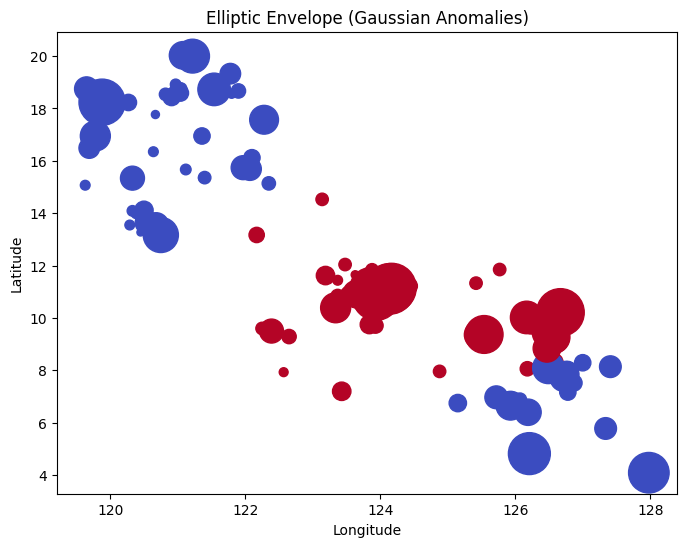

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(df["longitude"], df["latitude"],
            c=df["anomaly_elliptic"], cmap="coolwarm", s=df["magnitude"]**3 * 10)
plt.title("Elliptic Envelope (Gaussian Anomalies)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Scale features 0–1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)

# Define autoencoder
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(X_scaled.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_scaled, X_scaled, epochs=100, batch_size=8, verbose=0)

# Compute reconstruction error
recon = model.predict(X_scaled)
errors = ((X_scaled - recon)**2).mean(axis=1)
threshold = errors.mean() + 2*errors.std()

df["anomaly_autoencoder"] = (errors > threshold).astype(int)

/Users/maxellmilay/.pyenv/versions/3.12.0/envs/earthquake-prediction/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step


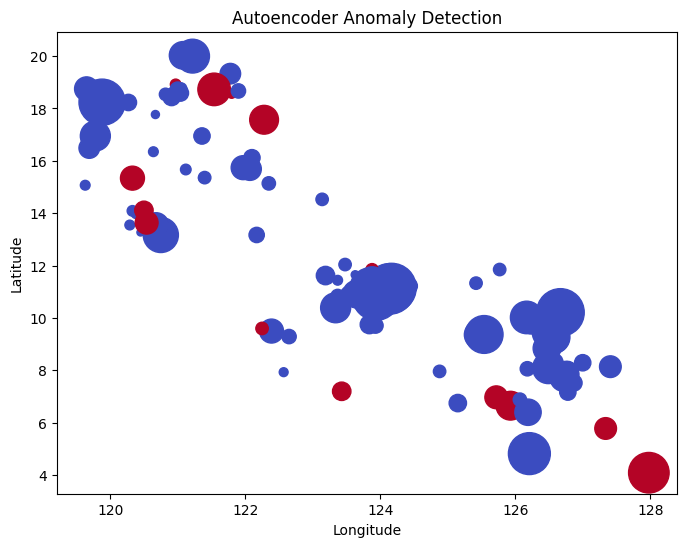

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(df["longitude"], df["latitude"],
            c=df["anomaly_autoencoder"], cmap="coolwarm", s=df["magnitude"]**3 * 10)
plt.title("Autoencoder Anomaly Detection")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()